In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas
import random



In [68]:
def getDataset():
    #import dataset
    raw = fetch_california_housing(as_frame=True)
    
    #get input and output
    X = raw.data.values
    X = np.array(X,dtype='float32')
    np.apply_along_axis(standardize,axis=1,arr=X)
    Y = raw.target.values
    Y = np.array(Y,dtype='float32')
    n = len(X)
    r = 0.8
    x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=1-r)
    
    x_val = x_train[int(len(x_train)*r):]
    part_x_train = x_train[:int(len(x_train)*r)]
    y_val = y_train[int(len(y_train)*r):]
    part_y_train = y_train[:int(len(y_train)*r)]
    
    train_data = torch.utils.data.TensorDataset(torch.from_numpy(part_x_train),torch.from_numpy(part_y_train))
    valid_data = torch.utils.data.TensorDataset(torch.from_numpy(x_val),torch.from_numpy(y_val))
    test_data =  torch.utils.data.TensorDataset(torch.from_numpy(x_test),torch.from_numpy(y_test))

    print(len(part_x_train))
    print(len(x_val))
    print(len(x_test))

    return train_data,valid_data,test_data,y_test

In [69]:
getDataset()


13209
3303
4128


(<torch.utils.data.dataset.TensorDataset at 0x7f3c1b34bbd0>,
 array([3.527  , 1.981  , 5.00001, ..., 1.836  , 1.734  , 2.306  ],
       dtype=float32))

In [5]:
def standardize(arr):
    arr[0] = (abs(arr[0]) - 3.870671003)/1.899821718
    arr[1] = (abs(arr[1]) - 28.63948643)/12.58555761
    arr[2] = (abs(arr[2]) - 5.428999742)/2.474173139
    arr[3] = (abs(arr[3]) - 1.09667515)/0.473910857
    arr[4] = (abs(arr[4]) - 1425.476744)/1132.462122
    arr[5] = (abs(arr[5]) - 3.070655159)/10.38604956
    arr[6] = (abs(arr[6]) - 35.63186143)/2.135952397
    arr[7] = (abs(arr[7]) - 119.5697045)/2.003531724

In [6]:
getDataset()

128
1502
19010


(<torch.utils.data.dataset.TensorDataset at 0x7f3c1ceaf350>,
 array([3.5  , 1.849, 0.691, ..., 1.625, 1.563, 1.638], dtype=float32))

In [7]:
class RegularDropOutModel(torch.nn.Module):
    def __init__(self,**kwargs):
        super(RegularDropOutModel,self).__init__()
        
        self.linear1 = torch.nn.Linear(8,first_layer_size)
        self.activation1 = torch.nn.Sigmoid()
        self.dropout1 = torch.nn.Dropout(p=float(kwargs['dropout_rate']))
        self.linear2 = torch.nn.Linear(first_layer_size,second_layer_size)
        self.activation2 = torch.nn.Sigmoid()
        self.dropout2 = torch.nn.Dropout(p=float(kwargs['dropout_rate']))
        self.linear3 = torch.nn.Linear(second_layer_size,third_layer_size)
        self.activation3 = torch.nn.Sigmoid()
        self.dropout3 = torch.nn.Dropout(p=float(kwargs['dropout_rate']))
        self.linear4 = torch.nn.Linear(third_layer_size,1)
        self.activation4 = torch.nn.ReLU()
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        x = self.activation3(x)
        x = self.dropout3(x)
        x = self.linear4(x)
        x = self.activation4(x)
        return x
         

In [8]:
class SWDropOut(torch.nn.Module):
    def __init__(self,**kwargs):
        super().__init__()
        self.group_size = int(kwargs['group_size'])
        self.drop_per_group = int(kwargs['drop_per_group'])
        self.scalar = 1/((self.group_size-self.drop_per_group)/self.group_size)
        
    def forward(self, x):
        if self.training:
            scalar_mask = torch.full(x.size(),self.scalar)
            for i in range(0,len(x),self.group_size):
                masked_count=0
                while masked_count < self.drop_per_group:
                    index = random.randint(0, self.group_size-1) 
                    if scalar_mask[i+index] !=0:
                        scalar_mask[i+index]=0
                        masked_count+=1
            x = torch.multiply(x,scalar_mask)
            return x
        else:
            return x


In [9]:
class SWDropOutModel(torch.nn.Module):
    def __init__(self,**kwargs):
        super(SWDropOutModel,self).__init__()
        
        self.linear1 = torch.nn.Linear(8,first_layer_size)
        self.activation1 = torch.nn.Sigmoid()
        self.dropout1 = SWDropOut(group_size=kwargs['group_size'],drop_per_group=kwargs['drop_per_group'])
        self.linear2 = torch.nn.Linear(first_layer_size,second_layer_size)
        self.activation2 = torch.nn.Sigmoid()
        self.dropout2 = SWDropOut(group_size=kwargs['group_size'],drop_per_group=kwargs['drop_per_group'])
        self.linear3 = torch.nn.Linear(second_layer_size,third_layer_size)
        self.activation3 = torch.nn.Sigmoid()
        self.dropout3 = SWDropOut(group_size=kwargs['group_size'],drop_per_group=kwargs['drop_per_group'])
        self.linear4 = torch.nn.Linear(third_layer_size,1)
        self.activation4 = torch.nn.ReLU()
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        x = self.activation3(x)
        x = self.dropout3(x)
        x = self.linear4(x)
        x = self.activation4(x)
        return x
        
 

In [10]:
def train(dataset, mdl, optm, loss_func):
    mdl.train(True)
    running_loss=0
    count=0
    for x,y in dataset:
        optm.zero_grad()
        output = mdl(x)
    
        training_loss = loss_func(output, torch.unsqueeze(y,0))
        training_loss.backward()
        
        optm.step()
        
        running_loss += training_loss.item()
        count+=1
        
    return running_loss/count
        
@torch.no_grad()        
def validate(dataset, mdl, loss_func):
    mdl.eval()
    running_val_loss=0
    count=0
    with torch.no_grad():
        for x,y in dataset:
            output = mdl(x)
            validation_loss = loss_func(output, torch.unsqueeze(y,0))
            running_val_loss += validation_loss.item()
            count+=1
            
    return running_val_loss/count
 
@torch.no_grad()       
def predict(dataset, mdl,loss_func):
    mdl.eval()
    predictions=[]
    test_loss=0
    count=0
    with torch.no_grad():
        for x,y in dataset:
            output = mdl(x)
            test_loss+=loss_func(output,torch.unsqueeze(y,0))
            predictions.append(float(output))
            count+=1
    return predictions,(test_loss/count)
        


In [11]:
def train_and_test_dropout(training,validation,testing,epochs,dropout_rate):
    DO_model = RegularDropOutModel(dropout_rate=dropout_rate)
    DO_optimizer = torch.optim.SGD(DO_model.parameters(recurse=True),lr=0.01)
    loss_fn = torch.nn.MSELoss()
    train_loss =[]
    val_loss=[]
    for _ in epochs:
        loss = train(training,DO_model,DO_optimizer,loss_fn)
        valid_loss = validate(validation,DO_model,loss_fn)
        train_loss.append(loss)
        val_loss.append(valid_loss)

    y_pred,test_loss = predict(testing,DO_model,loss_fn)
    
    return train_loss,val_loss,test_loss,y_pred

In [12]:
def train_and_test_sw_dropout(training,validation,testing,epochs,group_size,drop_per_group):
    SWDO_model = SWDropOutModel(group_size=group_size,drop_per_group=drop_per_group)
    SWDO_optimizer = torch.optim.SGD(SWDO_model.parameters(recurse=True),lr=0.01)
    loss_fn = torch.nn.MSELoss()
    train_loss =[]
    val_loss=[]
    for _ in epochs:
        loss = train(training,SWDO_model,SWDO_optimizer,loss_fn)
        valid_loss = validate(validation,SWDO_model,loss_fn)
        train_loss.append(loss)
        val_loss.append(valid_loss)

    y_pred,test_loss = predict(testing,SWDO_model,loss_fn)
    
    return train_loss,val_loss,test_loss,y_pred

In [13]:
def makeGraph(loss, val_loss,y_hat,y_true,epochs):
    fig, (ax11,ax12) = plt.subplots(2,1)
    fig.set_figwidth(6)
    fig.set_figheight(12)
    
    ax11.set_title('Regular DropOut')
    ax11.plot(epochs,loss,'bo',label='Training Loss')
    ax11.plot(epochs,val_loss,'r',label='Validation Loss')
    ax11.set(xlabel='Epochs',ylabel='Loss')
    ax11.set_ylim(0.1,1.5)
    ax11.legend()
    
    x_temp=[-.25,5.5]
    y_temp=[-0.25,5.5]
    ax12.scatter(y_true,y_hat,s=2)
    ax12.plot(x_temp, y_temp, 'r')
    ax12.set(xlabel='Actual',ylabel='Predicted')
    ax12.set_ylim(-.25,5.5)
    ax12.set_xlim(-.25,5.5)
    
    plt.show()

In [14]:
def makeGraphs_2(do_loss, do_val_loss,do_y_hat,gbdo_loss, gbdo_val_loss,gbdo_y_hat,y_true,epochs):
    fig, ((ax11,ax21),(ax12,ax22)) = plt.subplots(2,2)
    fig.set_figwidth(12)
    fig.set_figheight(12)
    
    ax11.set_title('Regular DropOut')
    ax11.plot(epochs,do_loss,'bo',label='Training Loss')
    ax11.plot(epochs,do_val_loss,'r',label='Validation Loss')
    ax11.set(xlabel='Epochs',ylabel='Loss')
    ax11.set_ylim(0.1,1.5)
    ax11.legend()
    
    x_temp=[-.25,5.5]
    y_temp=[-0.25,5.5]
    ax12.scatter(y_true,do_y_hat,s=2)
    ax12.plot(x_temp, y_temp, 'r')
    ax12.set(xlabel='Actual',ylabel='Predicted')
    ax12.set_ylim(-.25,5.5)
    ax12.set_xlim(-.25,5.5)
    
    ax21.set_title('Inverse Group Based DropOut')
    ax21.plot(epochs,gbdo_loss,'bo',label='Training Loss')
    ax21.plot(epochs,gbdo_val_loss,'r',label='Validation Loss')
    ax21.set(xlabel='Epochs',ylabel='Loss')
    ax21.set_ylim(0.1,1.5)
    ax21.legend()
   
    ax22.scatter(y_true,gbdo_y_hat,s=2)
    ax22.plot(x_temp, y_temp, 'r')
    ax22.set(xlabel='Actual',ylabel='Predicted')
    ax22.set_ylim(-.25,5.5)
    ax22.set_xlim(-.25,5.5)
    plt.show()

In [15]:
def overlayGraphs(do_loss, do_val_loss,sw_loss, sw_val_loss,epochs):
    fig = plt.figure(constrained_layout=True)
    ax = fig.subplot_mosaic([['topL','topR'],['bottomL','bottomR']])
    fig.set_figwidth(12)
    fig.set_figheight(12)
    
    ax['bottomL'].set_title('DO & SW Validation Loss')
    ax['bottomL'].plot(epochs,do_val_loss,'b',label='Regular')
    ax['bottomL'].set_ylim([0.0,4.5])
    ax['bottomL'].set(xlabel='Epochs',ylabel='Loss')
    ax['bottomL'].plot(epochs,sw_val_loss,'g',label='Sector-Wise')
    ax['bottomL'].legend()
    
    ax['bottomR'].set_title('DO & SW Training Loss')
    ax['bottomR'].plot(epochs,do_loss,'bo',label='Regular')
    ax['bottomR'].set_ylim([0.0,4.5])
    ax['bottomR'].set(xlabel='Epochs',ylabel='Loss')
    ax['bottomR'].plot(epochs,sw_loss,'go',label='Sector-Wise')
    ax['bottomR'].legend()
    
    ax['topL'].set_title('Regular DropOut')
    ax['topL'].plot(epochs,do_loss,'bo',label='Training Loss')
    ax['topL'].plot(epochs,do_val_loss,'r',label='Validation Loss')
    ax['topL'].set_ylim([0.0,4.5])
    ax['topL'].set(xlabel='Epochs',ylabel='Loss')
    ax['topL'].legend()
    
    ax['topR'].set_title('Sector-Wise DropOut')
    ax['topR'].plot(epochs,sw_loss,'bo',label='Training Loss')
    ax['topR'].plot(epochs,sw_val_loss,'r',label='Validation Loss')
    ax['topR'].set_ylim([0.0,4.5])
    ax['topR'].set(xlabel='Epochs',ylabel='Loss')
    ax['topR'].legend()
   
    plt.show()

In [16]:
def makeGraphs_3(do_loss, do_val_loss,do_y_hat,gbdo_loss, gbdo_val_loss,gbdo_y_hat,inverse_loss, inverse_val_loss,inverse_y_hat,y_true,epochs):
    fig, ((ax11,ax21,ax31),(ax12,ax22,ax32)) = plt.subplots(2,3)
    fig.set_figwidth(18)
    fig.set_figheight(12)
    
    ax11.set_title('Regular DropOut')
    ax11.plot(epochs,do_loss,'bo',label='Training Loss')
    ax11.plot(epochs,do_val_loss,'r',label='Validation Loss')
    ax11.set(xlabel='Epochs',ylabel='Loss')
    ax11.set_ylim(0.1,1.5)
    ax11.legend()
    
    x_temp=[-.25,5.5]
    y_temp=[-0.25,5.5]
    ax12.scatter(y_true,do_y_hat,s=2)
    ax12.plot(x_temp, y_temp, 'r')
    ax12.set(xlabel='Actual',ylabel='Predicted')
    ax12.set_ylim(-.25,5.5)
    ax12.set_xlim(-.25,5.5)
    
    ax21.set_title('Group Based DropOut')
    ax21.plot(epochs,gbdo_loss,'bo',label='Training Loss')
    ax21.plot(epochs,gbdo_val_loss,'r',label='Validation Loss')
    ax21.set(xlabel='Epochs',ylabel='Loss')
    ax21.set_ylim(0.1,1.5)
    ax21.legend()
   
    ax22.scatter(y_true,gbdo_y_hat,s=2)
    ax22.plot(x_temp, y_temp, 'r')
    ax22.set(xlabel='Actual',ylabel='Predicted')
    ax22.set_ylim(-.25,5.5)
    ax22.set_xlim(-.25,5.5)
    
    ax31.set_title('Inverse Group Based DropOut')
    ax31.plot(epochs,inverse_loss,'bo',label='Training Loss')
    ax31.plot(epochs,inverse_val_loss,'r',label='Validation Loss')
    ax31.set(xlabel='Epochs',ylabel='Loss')
    ax31.set_ylim(0.1,1.5)
    ax31.legend()
   
    ax32.scatter(y_true,inverse_y_hat,s=2)
    ax32.plot(x_temp, y_temp, 'r')
    ax32.set(xlabel='Actual',ylabel='Predicted')
    ax32.set_ylim(-.25,5.5)
    ax32.set_xlim(-.25,5.5)
    
    
    
    plt.show()

In [17]:
global first_layer_size
global second_layer_size
global third_layer_size
training_data, valid_data, test_data, y_true = getDataset()

128
1502
19010


In [70]:

epochs = range(300)
dropout_rate = .10
group_size=10
drop_per_group=1
first_layer_size = 60
second_layer_size = 60
third_layer_size = 30

t_loss_dropout90, v_loss_dropout90, tst_loss_dropout90, y_pred_dropout90 = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
t_loss_swdo90,    v_loss_swdo90,    tst_loss_swdo90,    y_pred_swdo90    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)

print("SWDO Test Loss = ",tst_loss_swdo90)
print("  DO Test Loss = ",tst_loss_dropout90)

# overlayGraphs(t_loss_dropout90,v_loss_dropout90,t_loss_swdo90,v_loss_swdo90,epochs)


SWDO Test Loss =  tensor(0.5245)
  DO Test Loss =  tensor(0.5353)


SWDO Test Loss =  tensor(0.5313)
  DO Test Loss =  tensor(0.5593)


SWDO Test Loss =  tensor(0.5379)
  DO Test Loss =  tensor(0.5562)


SWDO Test Loss =  tensor(0.5418)
  DO Test Loss =  tensor(0.5696)


SWDO Test Loss =  tensor(0.5107)
  DO Test Loss =  tensor(0.6777)


SWDO Test Loss =  tensor(0.5189)
  DO Test Loss =  tensor(0.6242)


SWDO Test Loss =  tensor(0.5647)
  DO Test Loss =  tensor(0.7257)


SWDO Test Loss =  tensor(0.6225)
  DO Test Loss =  tensor(1.3289)


SWDO Test Loss =  tensor(0.6542)
  DO Test Loss =  tensor(1.3292)


SWDO Test Loss =  tensor(5.5959)
  DO Test Loss =  tensor(1.3308)


<function matplotlib.pyplot.show(close=None, block=None)>

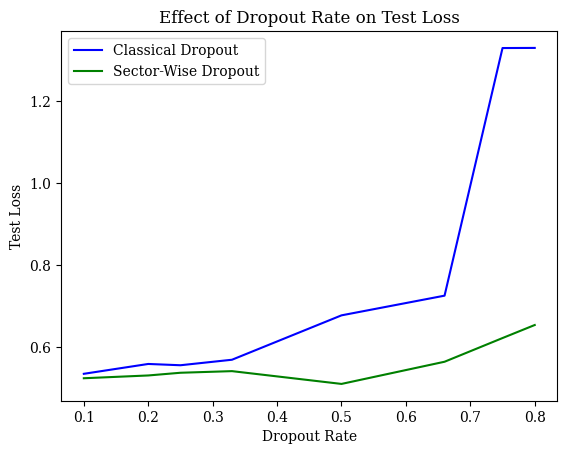

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


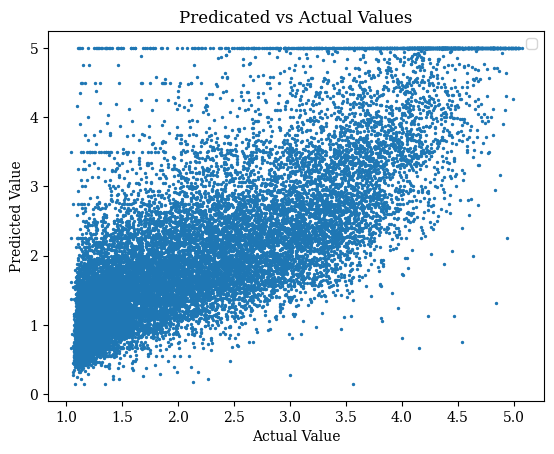

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


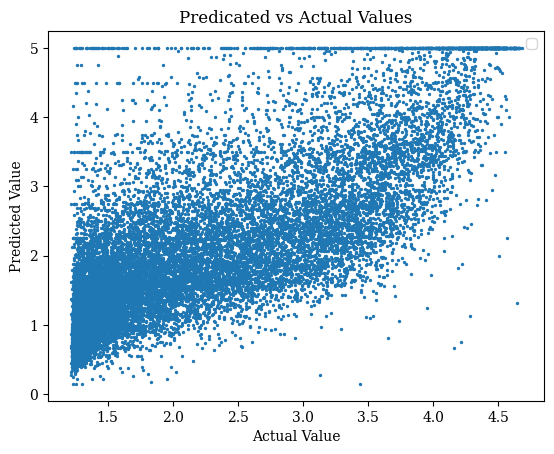

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


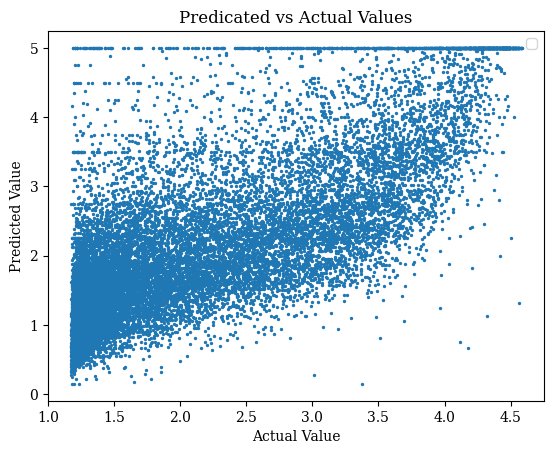

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


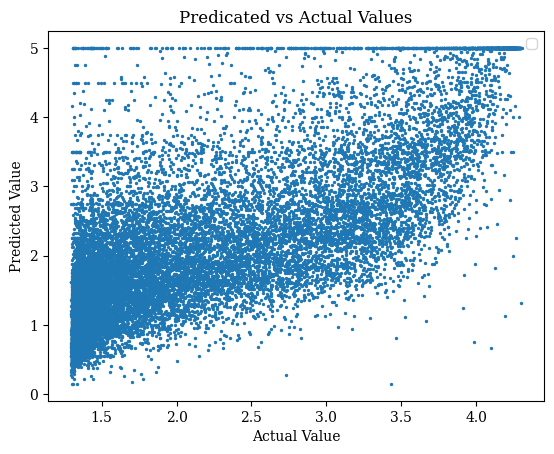

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


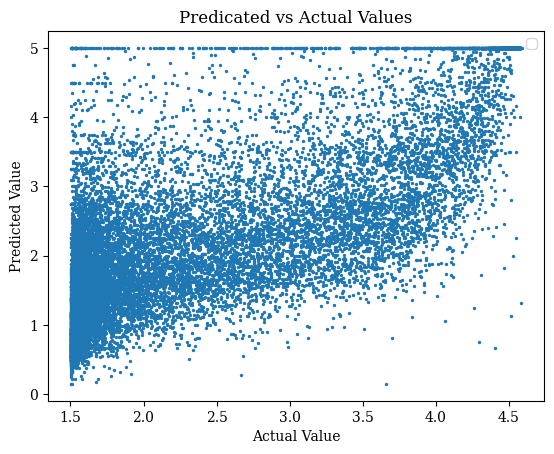

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


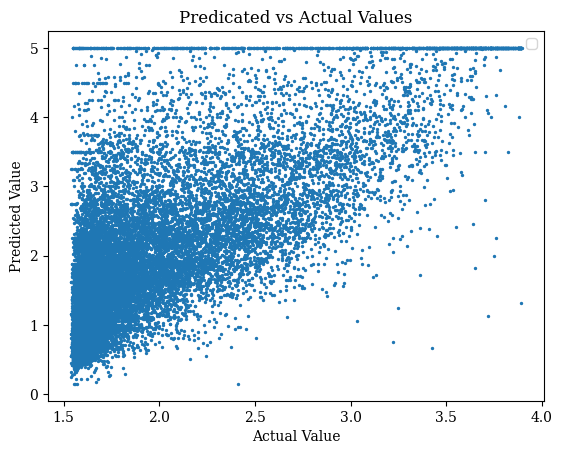

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


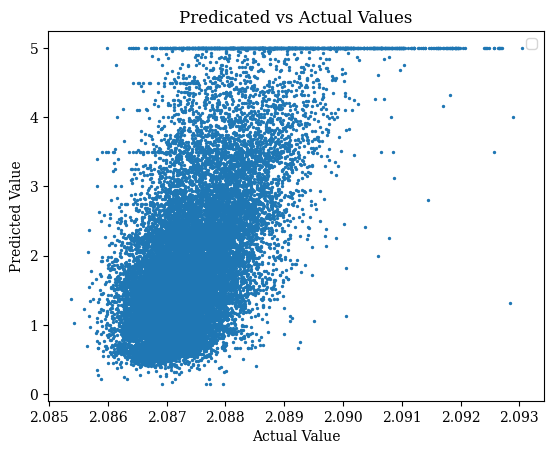

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


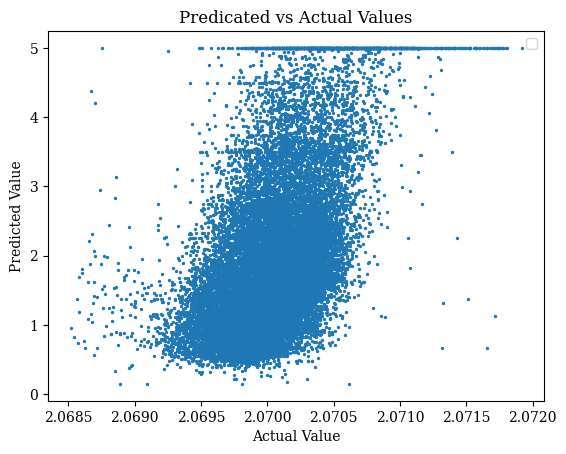

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


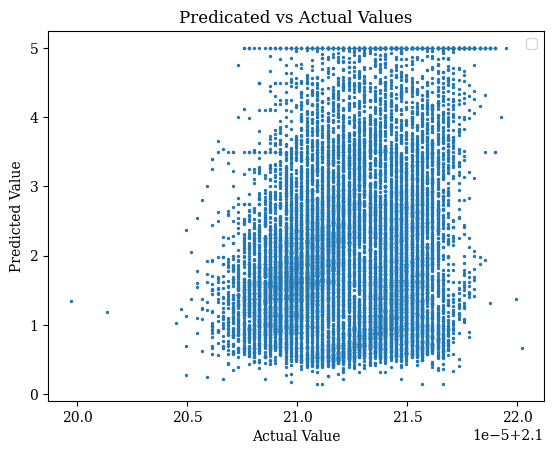

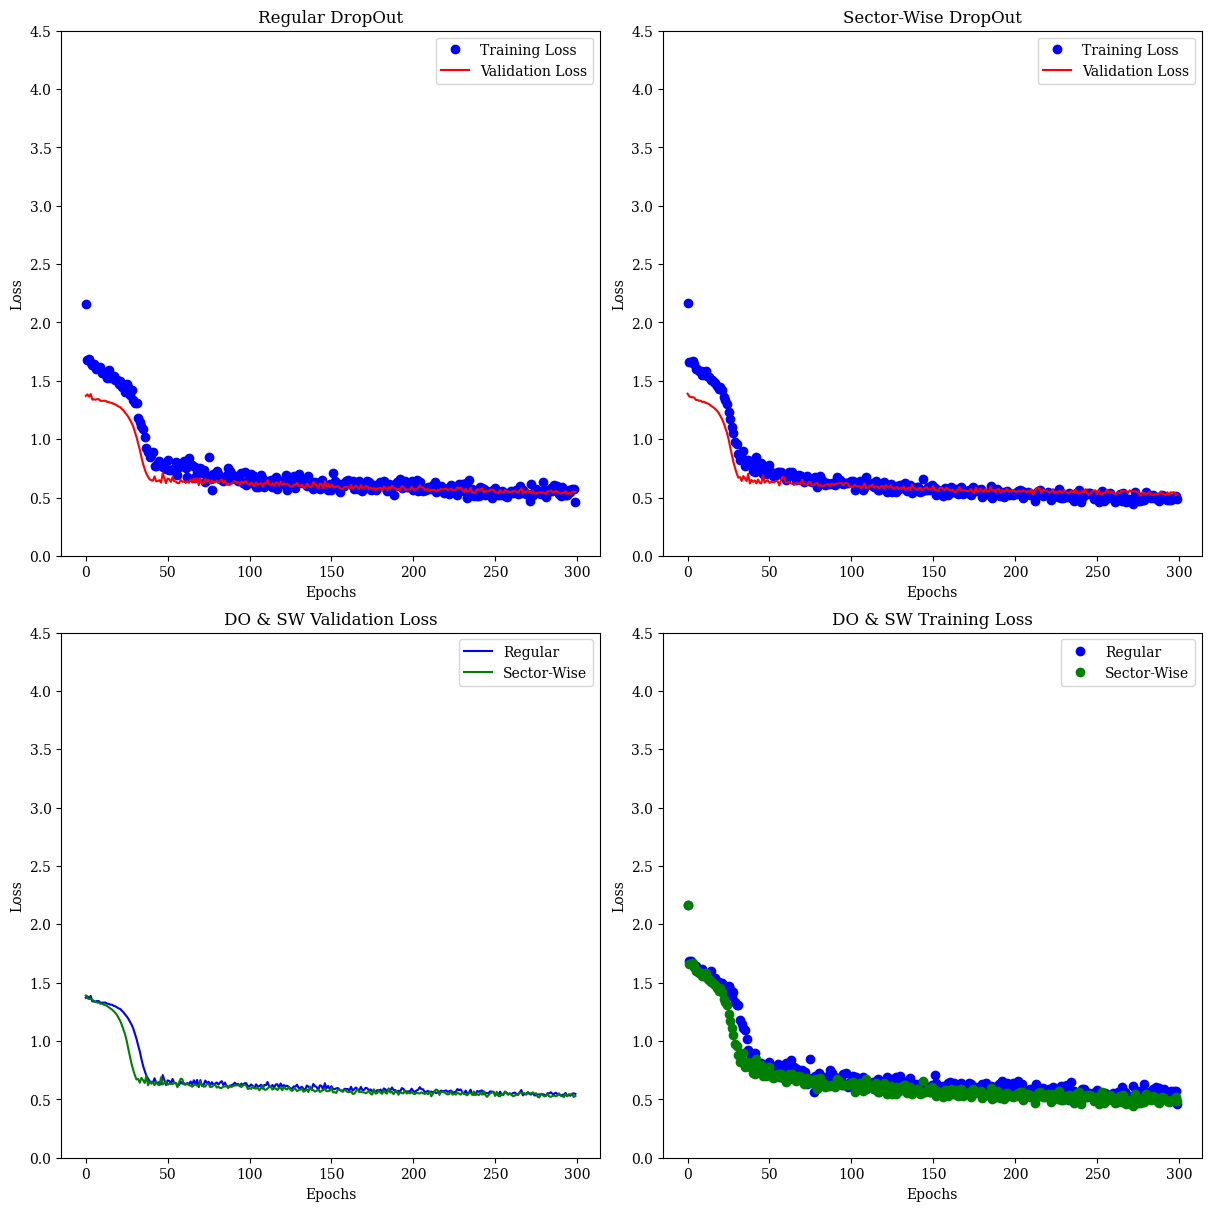

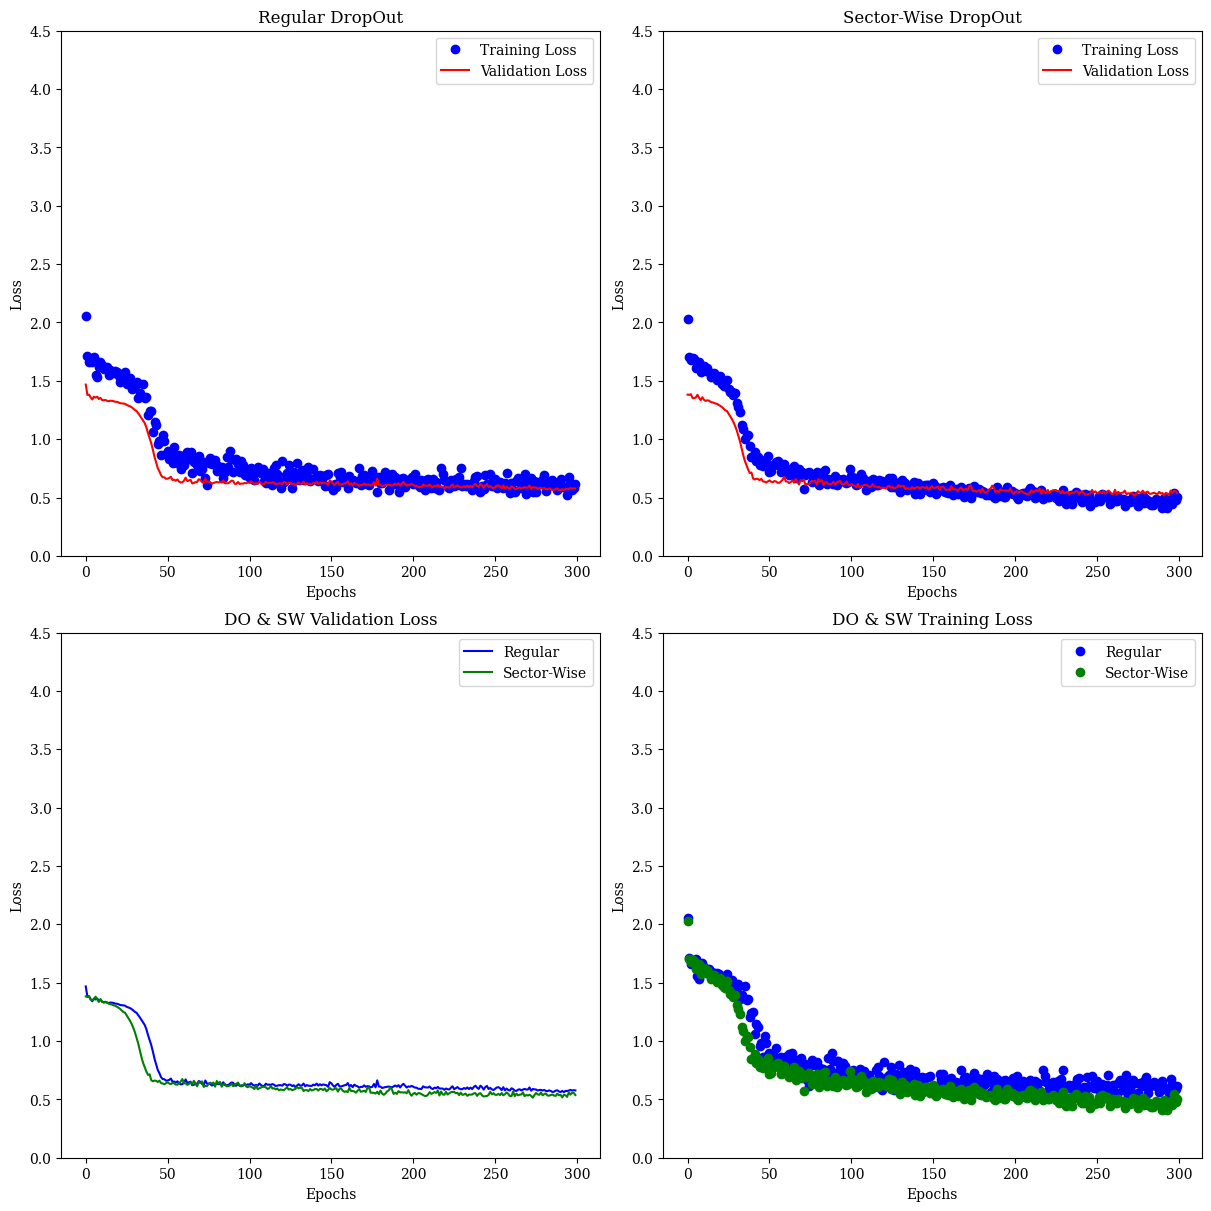

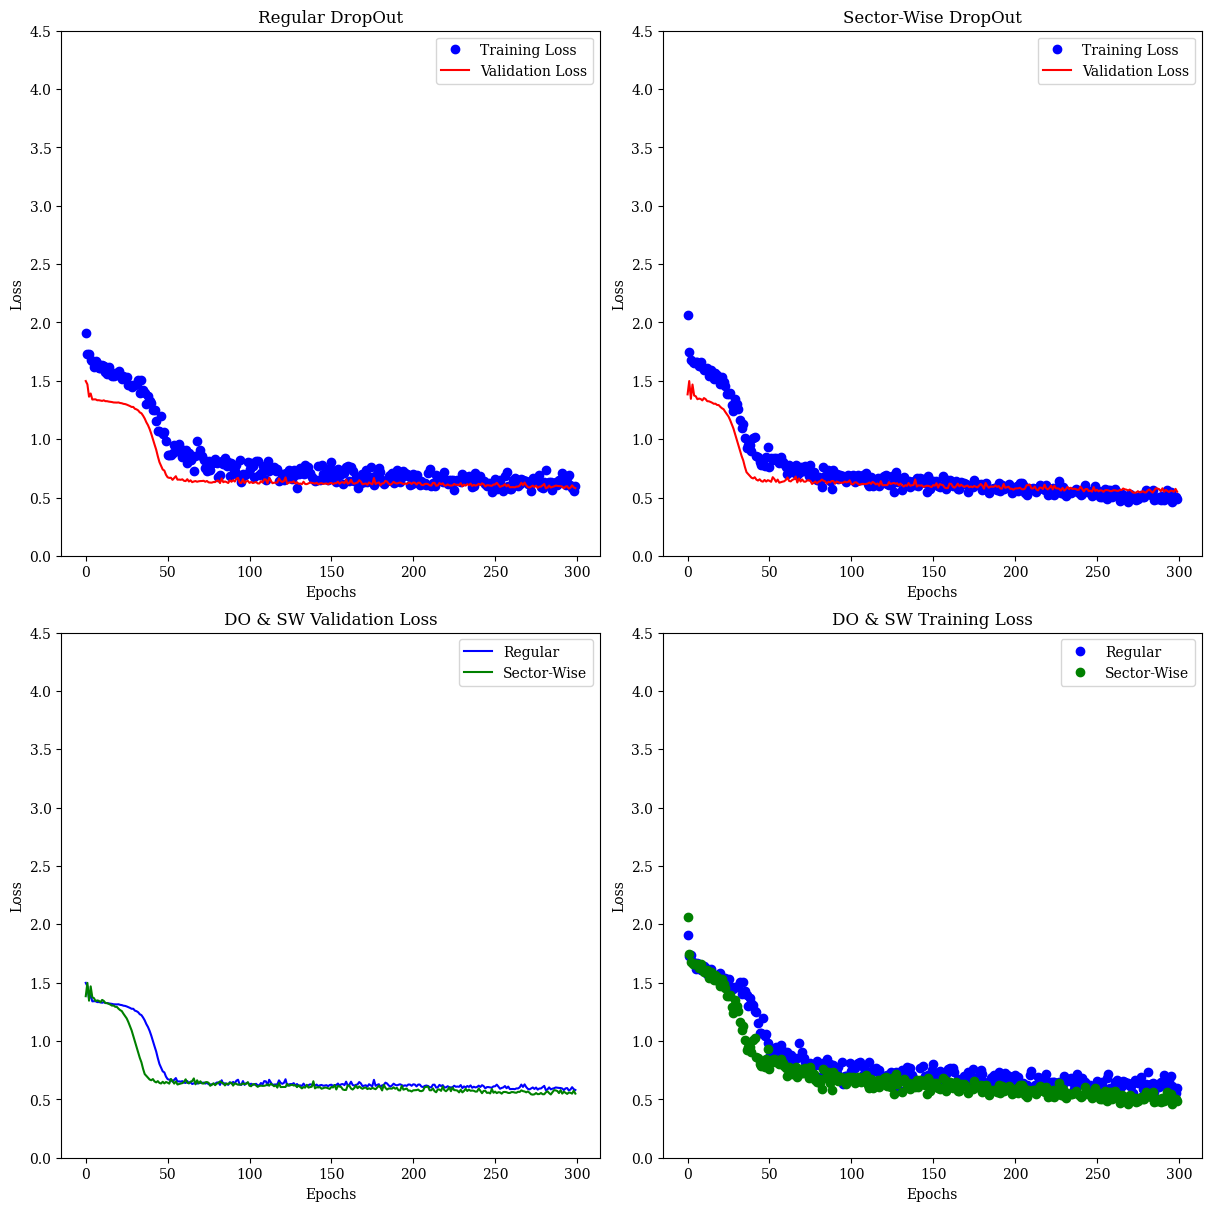

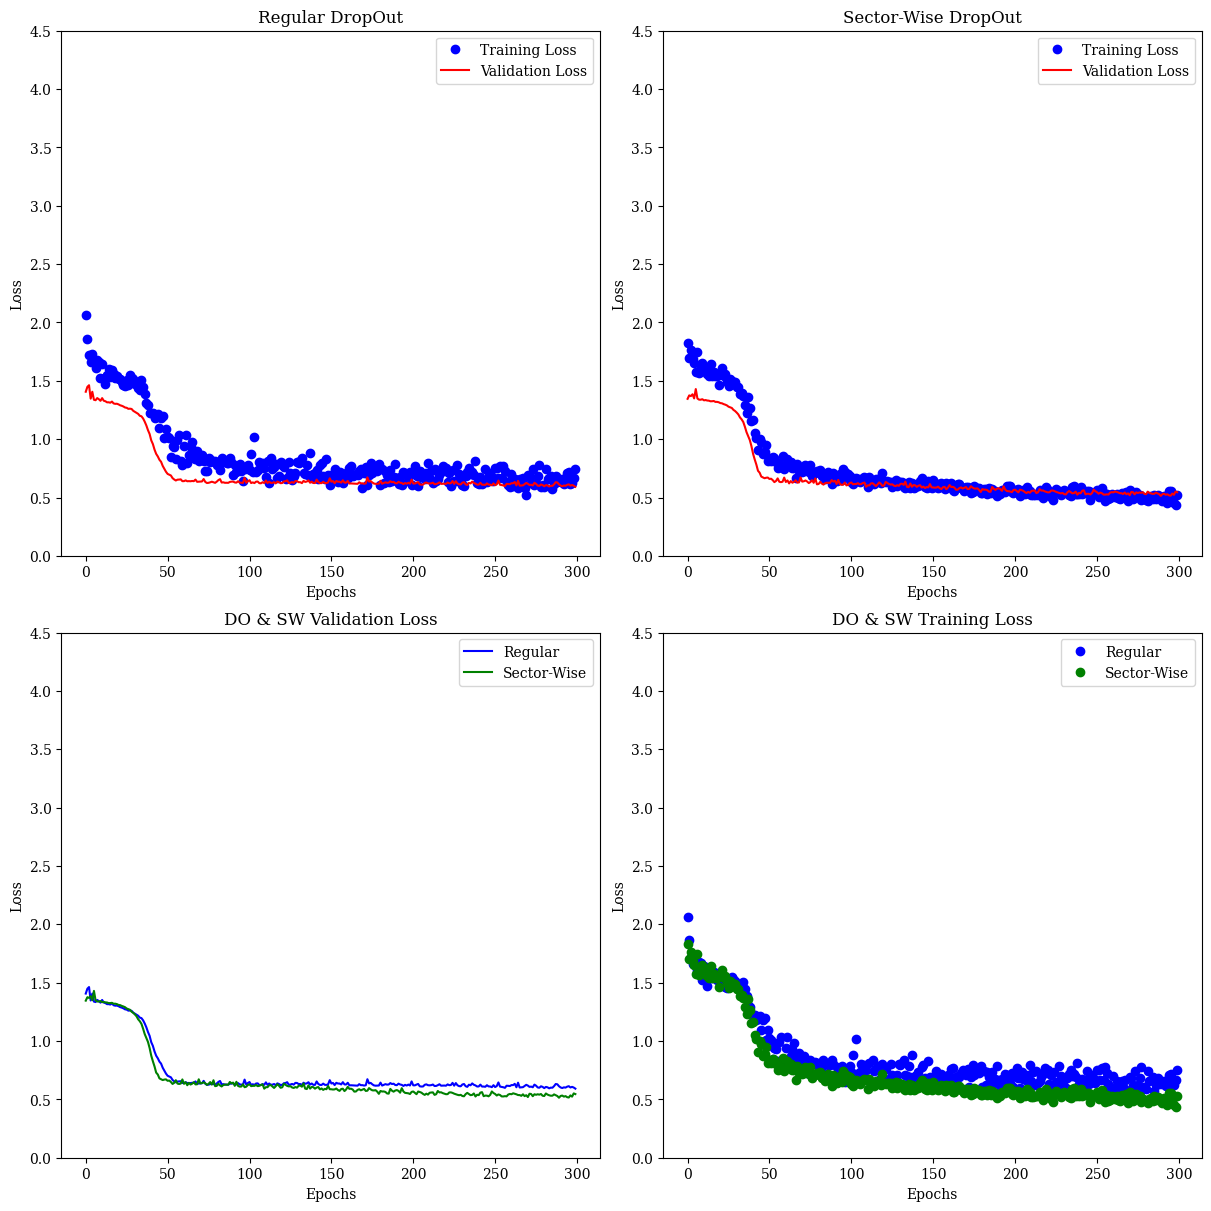

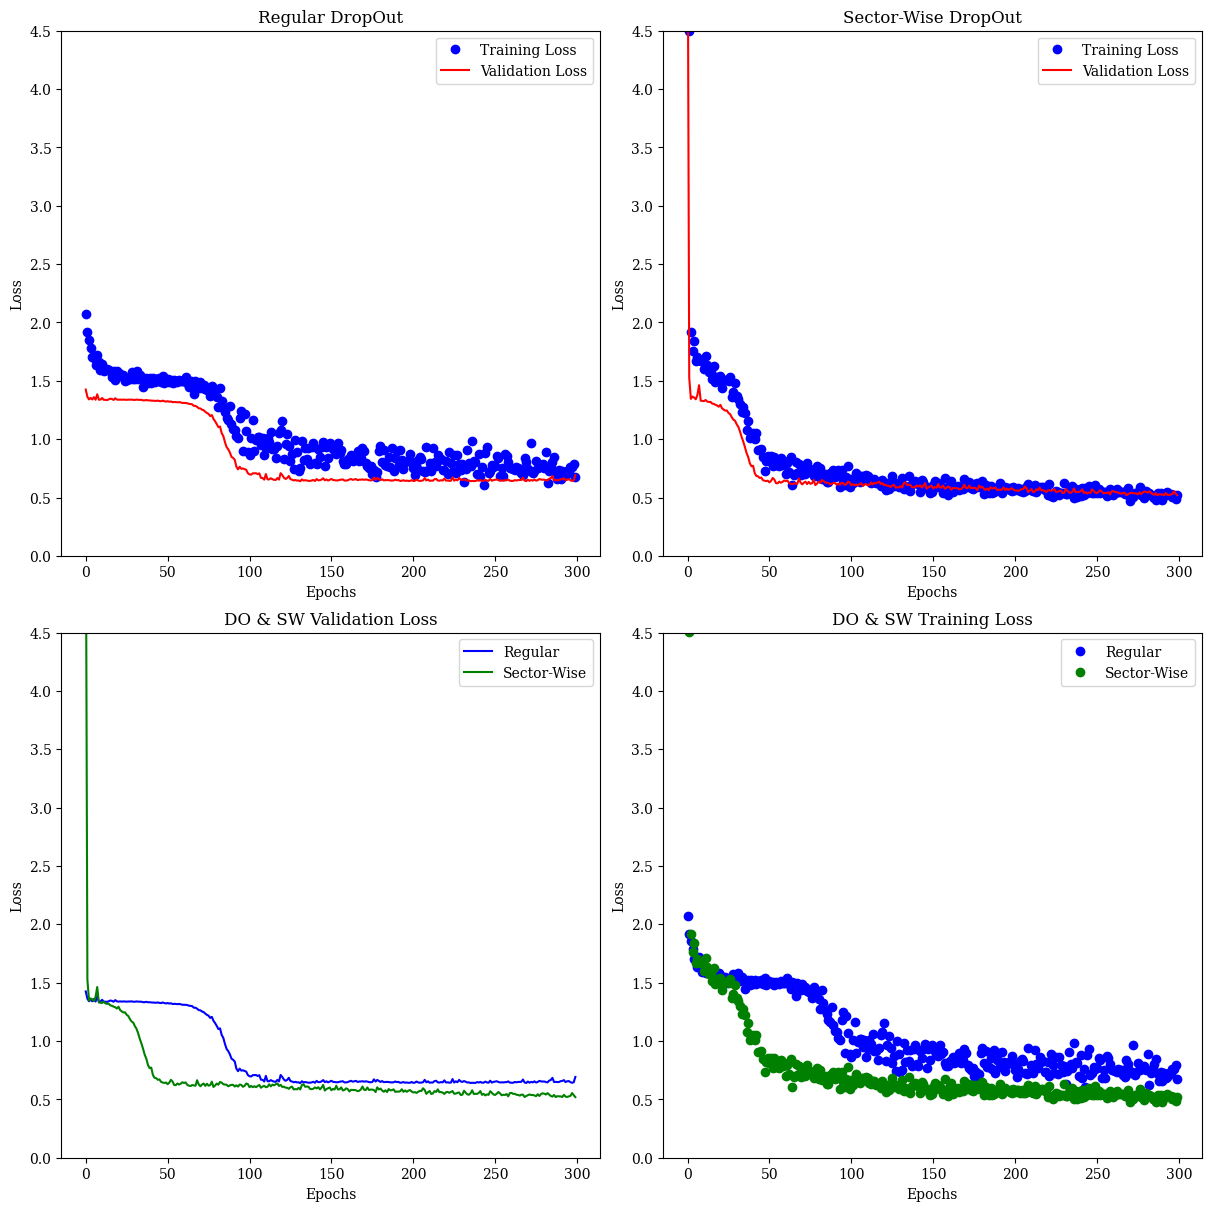

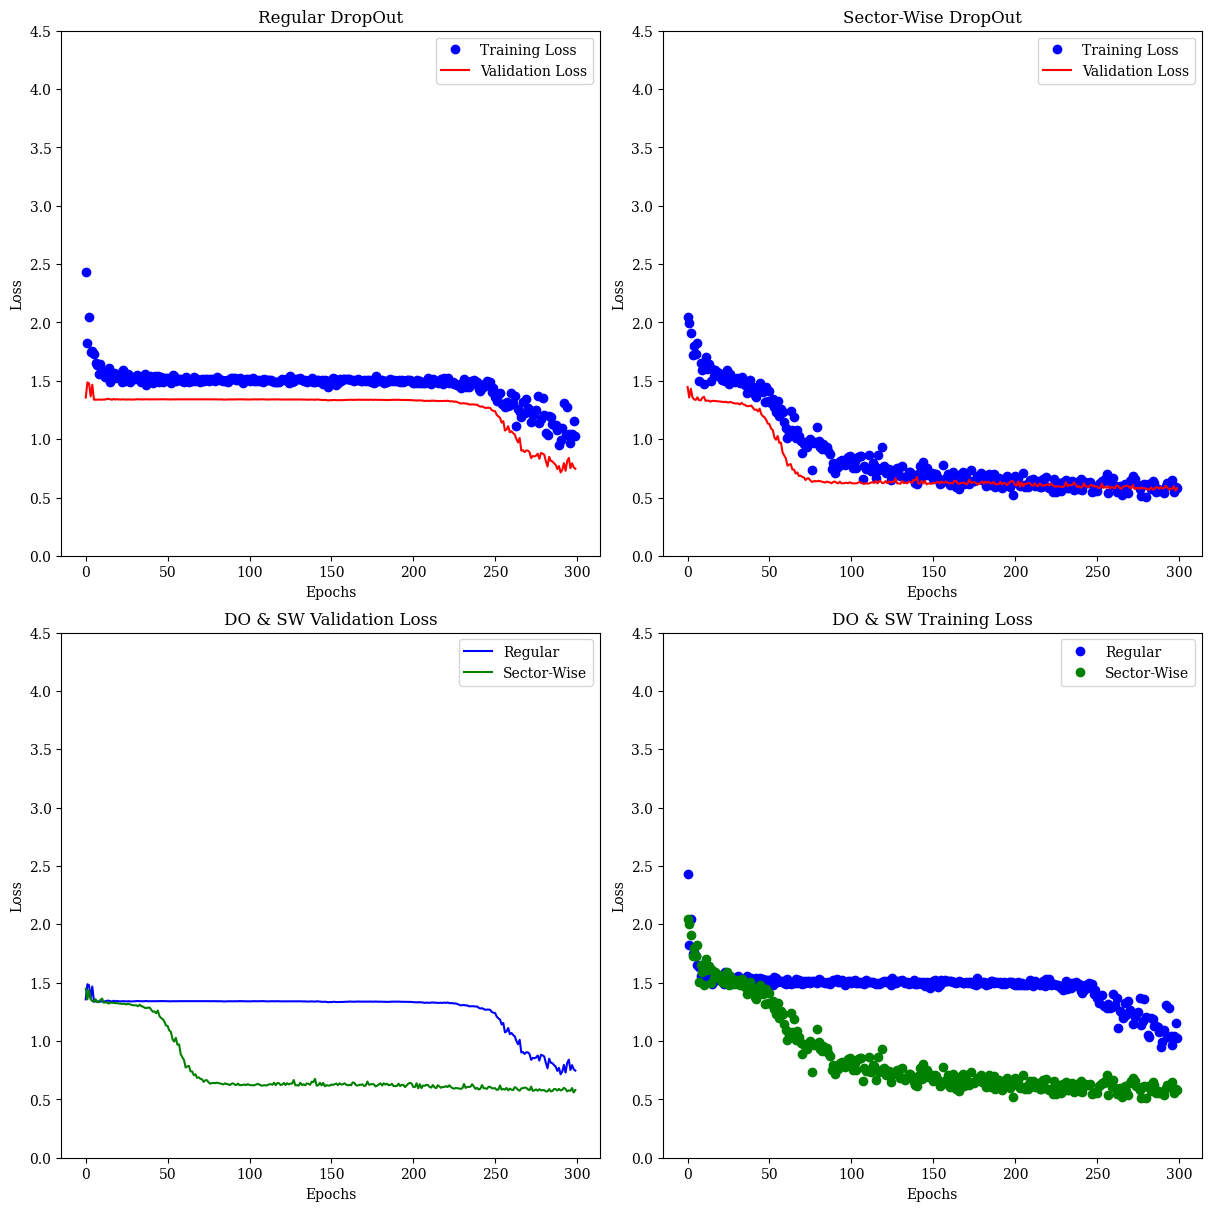

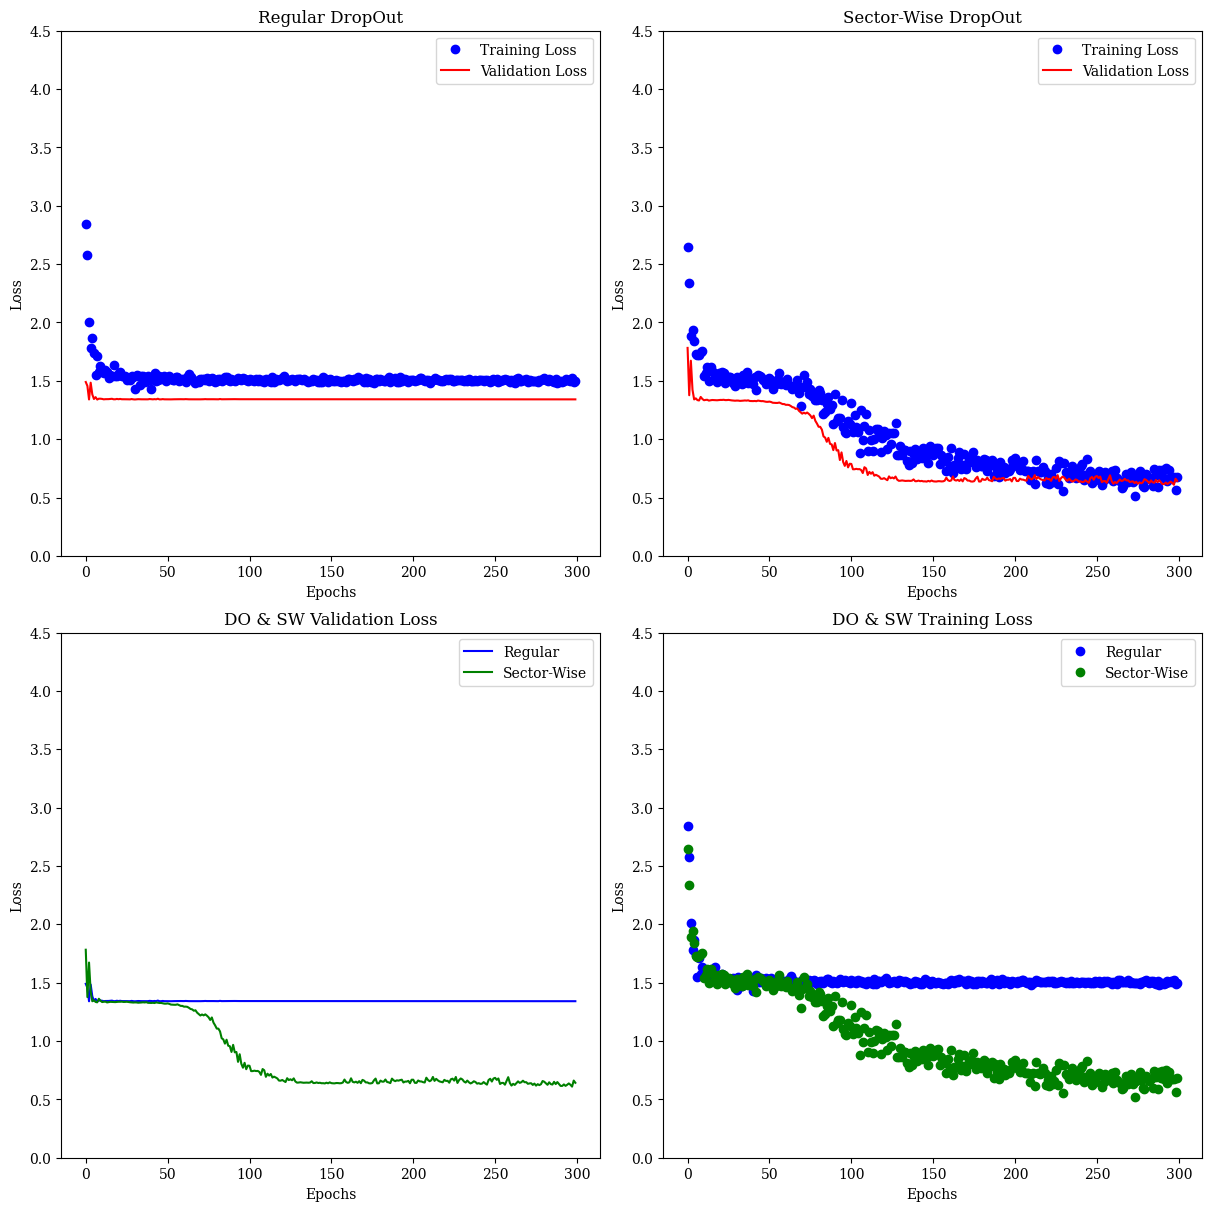

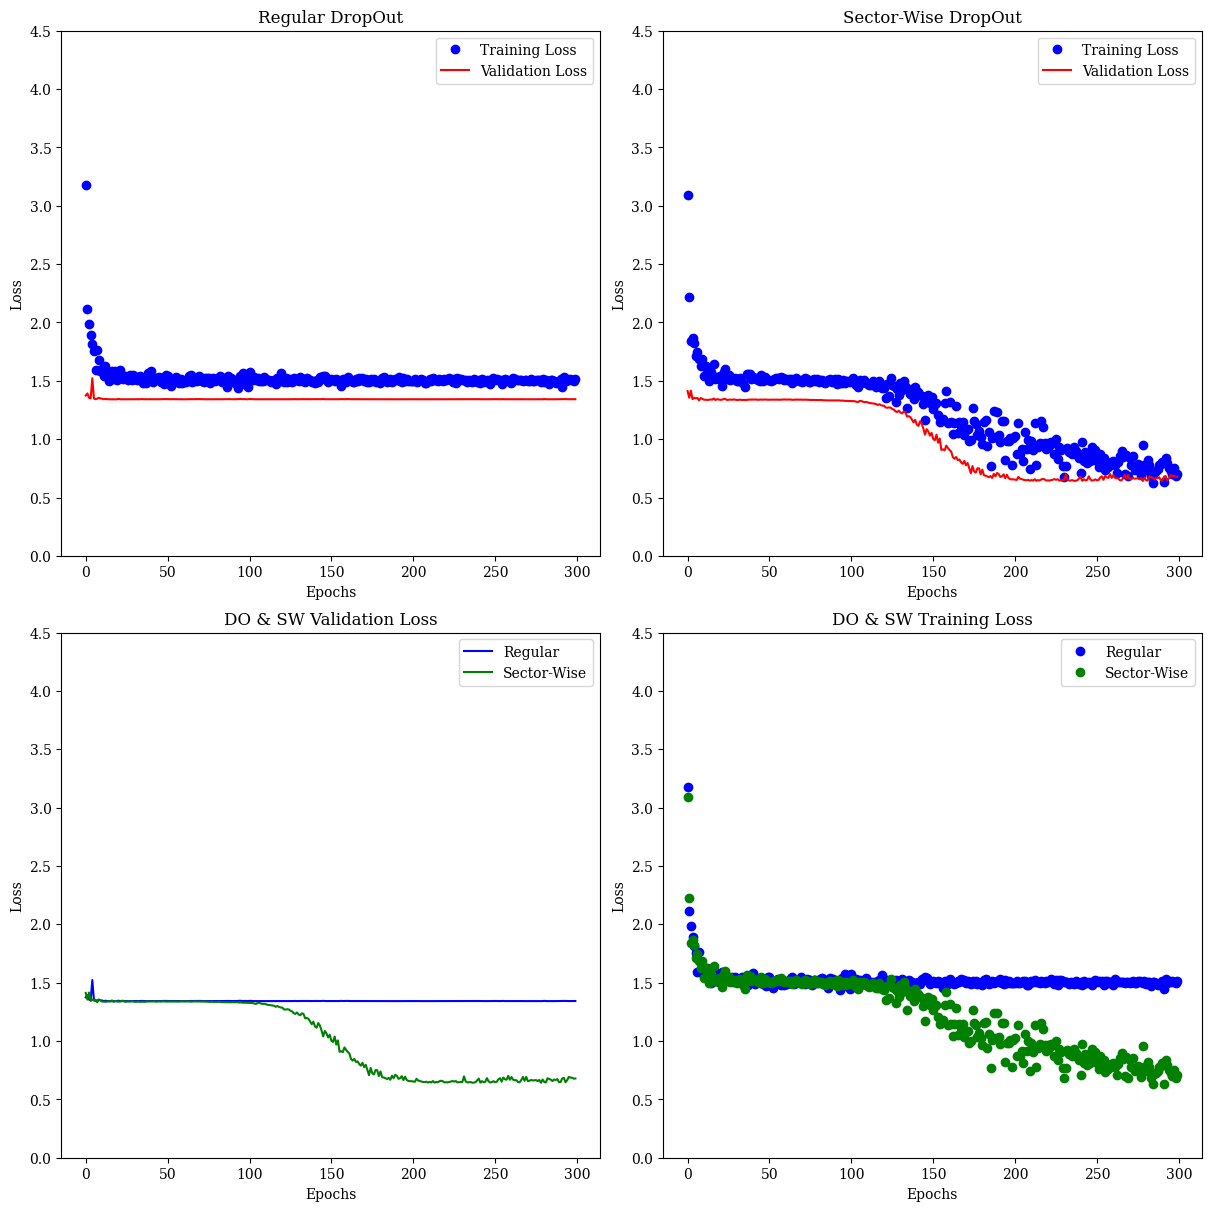

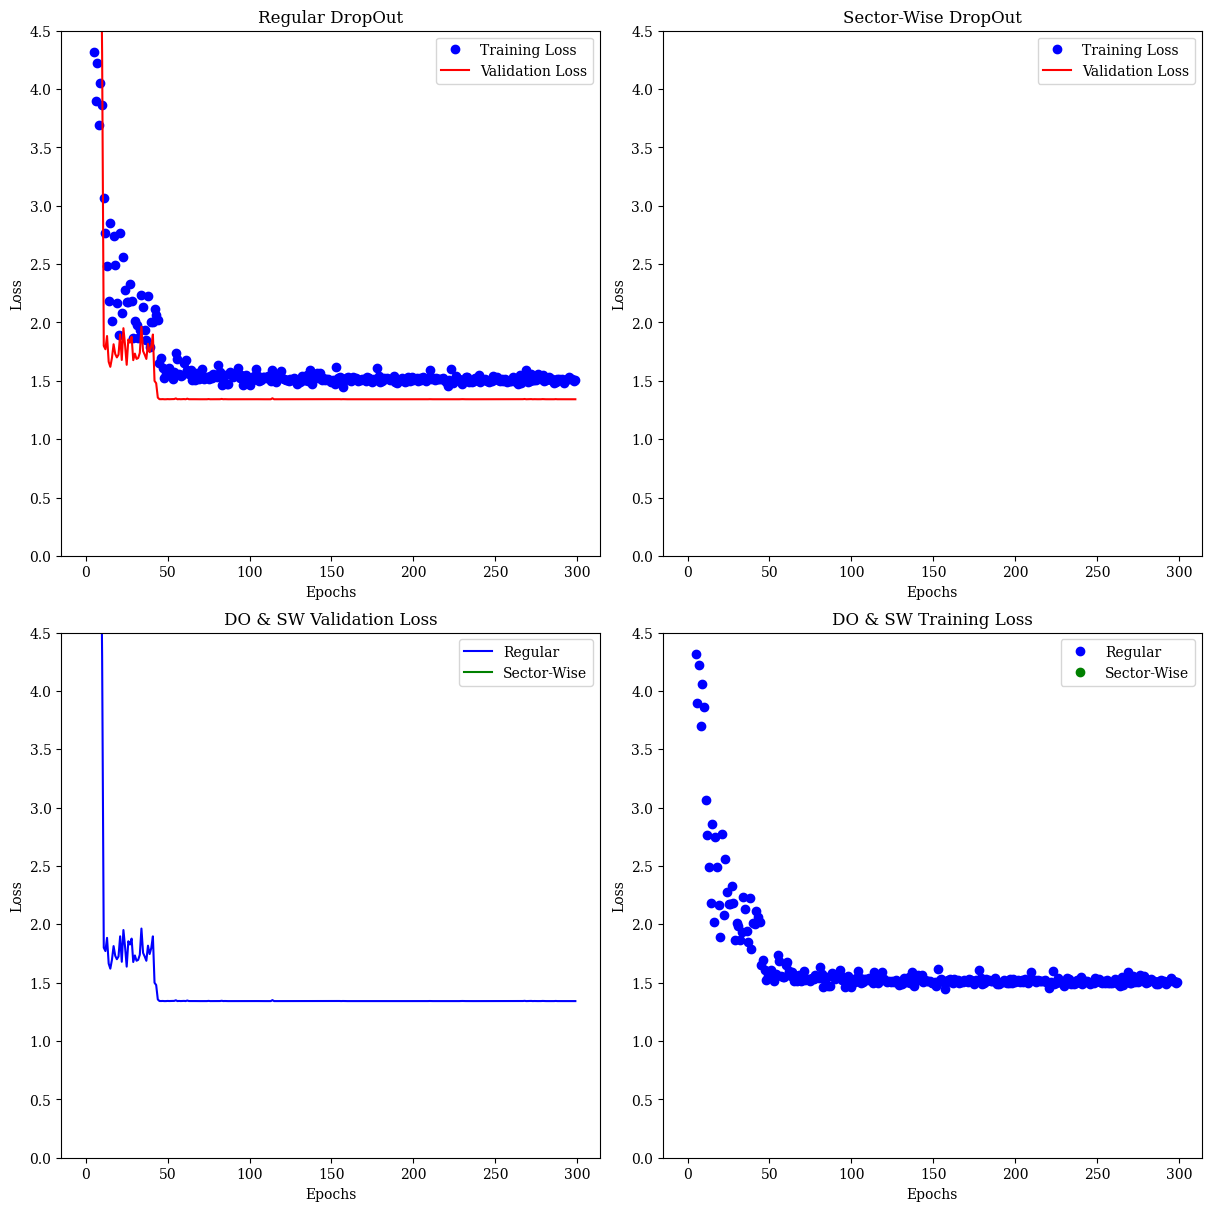

SWDO Test Loss =  tensor(0.5687)
  DO Test Loss =  tensor(0.5853)


<function matplotlib.pyplot.show(close=None, block=None)>

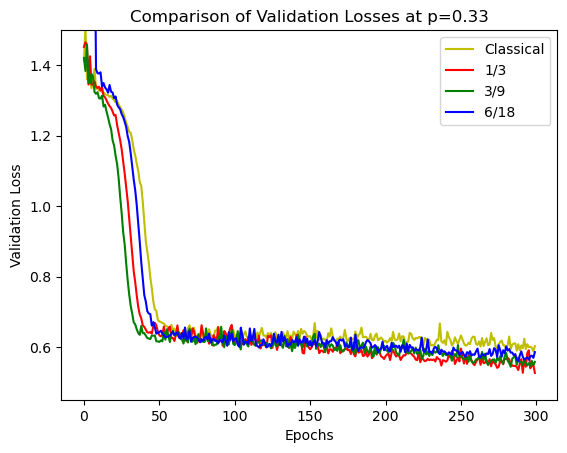

<function matplotlib.pyplot.show(close=None, block=None)>

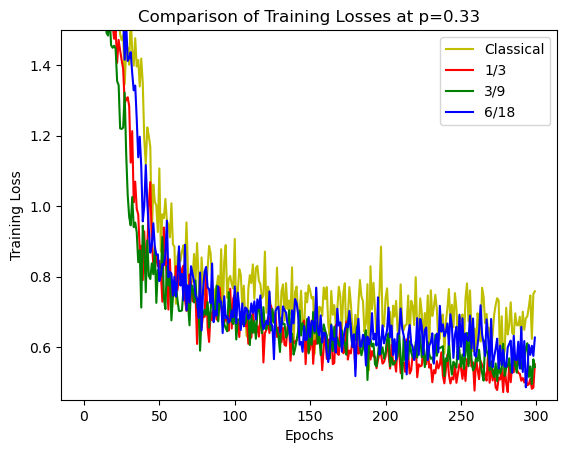

SWDO Test Loss =  tensor(0.5709)
  DO Test Loss =  tensor(0.6151)


<function matplotlib.pyplot.show(close=None, block=None)>

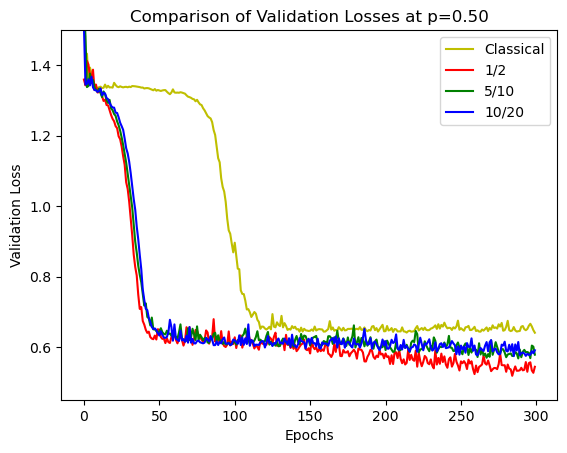

<function matplotlib.pyplot.show(close=None, block=None)>

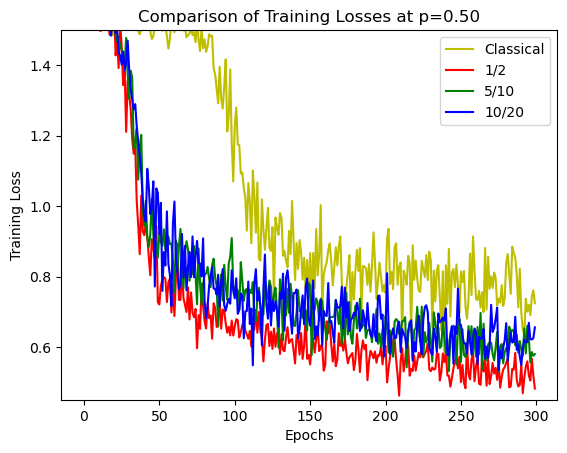

SWDO Test Loss =  tensor(0.6116)
  DO Test Loss =  tensor(1.2875)


<function matplotlib.pyplot.show(close=None, block=None)>

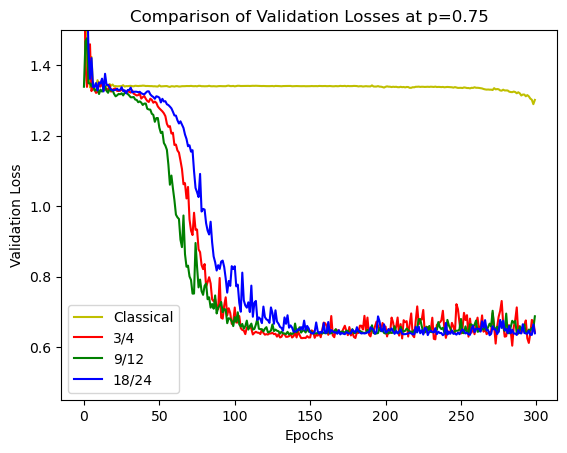

<function matplotlib.pyplot.show(close=None, block=None)>

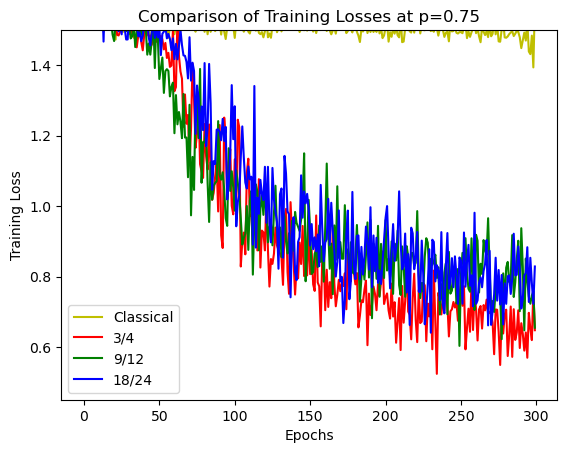